Name: Priyanshu Singh; 
Roll No: 21ME3AI33; 
Title: Zepto Recommendation Case Study

Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
nlp = spacy.load('en_core_web_lg')

In [2]:
#Reading input CSV
df=pd.read_csv('session_data.csv')

In [3]:
df.shape

(345152, 2)

In [4]:
df.nunique()

session_id      165335
product_name       396
dtype: int64

Data Pre-Processing

In [5]:
#Removing & and , or any special character and treating words with and and , as separte words
def split_products(row):
    products = row['product_name'].replace('&', ',').split(',')
    return [(row['session_id'], product.strip()) for product in products]

new_rows = []
for index, row in df.iterrows():
    new_rows.extend(split_products(row))

df = pd.DataFrame(new_rows, columns=['session_id', 'product_name'])
df.head()

,session_id,product_name
0,000ed966131fcb96e0efc4ff2b716a3e,beetroot
1,000ed966131fcb96e0efc4ff2b716a3e,cucumber
2,0013eab657eaf2d82d7f1e13023d95c2,onion
3,0013eab657eaf2d82d7f1e13023d95c2,long shelf life milk
4,0013fabde1e543dd541be925266aadbc,dates


In [6]:
df.isnull().sum()

session_id      0
product_name    0
dtype: int64

In [7]:
df.shape

(364141, 2)

In [8]:
#Mapping id's to some number and mapping product as well
unique_ids = df['session_id'].unique()
id_mapping = {id_: idx for idx, id_ in enumerate(unique_ids)}
# Replace alphanumeric session IDs with numeric values
df['id'] = df['session_id'].map(id_mapping)


product_mapping = {product: idx for idx, product in enumerate(df['product_name'].unique())}
product_mapping_inv = {idx: product for product, idx in product_mapping.items()} ##Inverse mapping given product gives it's mapping
df['product'] = df['product_name'].map(product_mapping)
df.drop(['session_id','product_name'], axis=1,inplace=True)

In [9]:
unique_products = list(product_mapping_inv.values())
unique_products

['beetroot',
 'cucumber',
 'onion',
 'long shelf life milk',
 'dates',
 'matchbox',
 'brinjal',
 'gourds',
 'notebook',
 'rain accessories',
 'earbuds',
 'bhujia',
 'sev',
 'roasted chana',
 'fried gram',
 'wafer cubes',
 'detergent powder',
 'garlic',
 'fresh cow milk',
 'oats',
 'male condoms',
 'sooji',
 'rawa',
 'chocolates',
 'cakes',
 'perfume gift sets',
 'almond',
 'curd',
 'chicken boneless cut',
 'chocolate cone',
 'shared pack chocolates',
 'tender coconut',
 'baby fruits',
 'body soaps',
 'watermelon',
 'deodorant body spray',
 'cream biscuits',
 'chickpea',
 'kabuli chana',
 'buffalo ghee',
 'pure ghee',
 'desi ghee',
 'fruit tub',
 'soapcase dispensers',
 'more',
 'milk breads',
 'coconut oil',
 'laddu',
 'hair color cream',
 'soya chunks',
 'diwali items',
 'salt',
 'cat wet food',
 'flavoured crackers',
 'premium chocolates',
 'gulab jamun pre-mix',
 'rice',
 'starters',
 'soup',
 'instant cup veg noodles',
 'face accessories',
 'meat masala',
 'poppy seeds',
 'khus-khu

In [10]:
df.head()

,id,product
0,0,0
1,0,1
2,1,2
3,1,3
4,2,4


Defining a Dataframe where each row consists of Session id and column contains of product bought

In [11]:
counted = df.groupby(['id', 'product']).size().reset_index(name='count')
pivot_table = counted.pivot(index='id', columns='product', values='count').fillna(0)

Calculating Frequency Matrix of products Bought Together

In [12]:
products = df['product'].unique()
product_count = len(products)
co_occurrence_matrix = pd.DataFrame(np.zeros((product_count, product_count)), index=products, columns=products)

# Fill the matrix
for session_id, session_data in df.groupby('id'):
    product_list = session_data['product'].tolist()
    for i in range(len(product_list)):
        for j in range(i + 1, len(product_list)):
            product_i = product_list[i]
            product_j = product_list[j]
            co_occurrence_matrix.loc[product_i, product_j] += 1
            co_occurrence_matrix.loc[product_j, product_i] += 1

In [13]:
#Replacing occurence of product 1 and 2 and 3 and 4 times with 0's as they are outliers
co_occurrence_matrix.replace(4, 0, inplace=True)
co_occurrence_matrix.replace(3, 0, inplace=True)
co_occurrence_matrix.replace(2, 0, inplace=True)
co_occurrence_matrix.replace(1, 0, inplace=True)

Filtering Words that are in Spacy Library

In [14]:
#Not inspecting the occult words which is not there in spacy dictionary
def find_empty_vector_words(name_list):
    empty_vector_words = []
    
    for name in name_list:
        name_doc = nlp(name)
        if name_doc.vector_norm == 0:
            empty_vector_words.append(name)
    
    return empty_vector_words
empty_vector_words = find_empty_vector_words(unique_products)
filtered_products = [product for product in unique_products if product not in empty_vector_words]
len(filtered_products)

405

Data Visualzation

C:\Users\NCS\AppData\Local\Temp\ipykernel_13012\3625614139.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=counts, y=product_names, palette=palette)


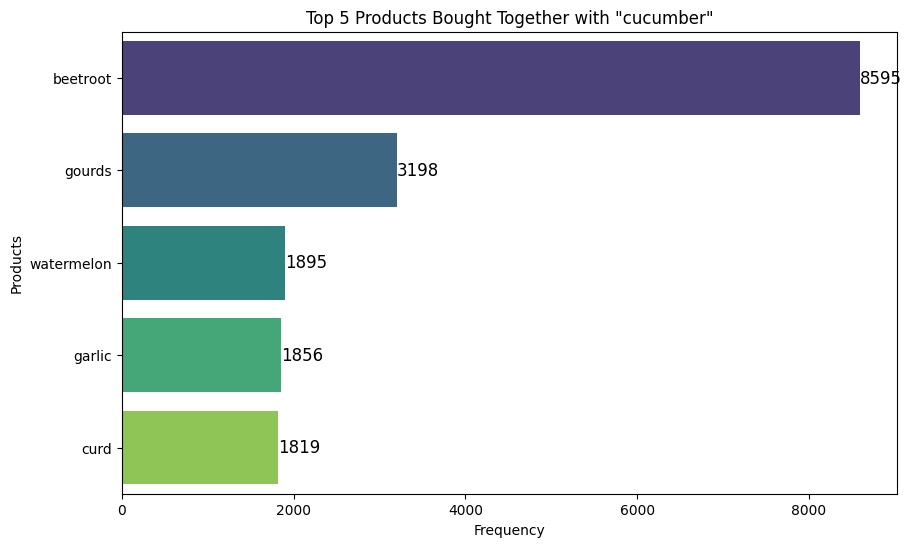

In [15]:
#Plotting Frequency of products bought together using transaction history
def plot_High_frequency_products(product_name, top_n=5):
    # Get the product ID from the mapping
    product_id = product_mapping.get(product_name)
    if product_id is None:
        raise ValueError(f"Product '{product_name}' not found in the data.")
    
    # Get co-occurrence counts for the given product
    co_purchased_counts = co_occurrence_matrix.loc[product_id]
    
    # Filter out products with count <= 0
    filtered_counts = co_purchased_counts[co_purchased_counts > 0]
    
    # Sort and get the top N products
    top_products = filtered_counts.sort_values(ascending=False).head(top_n)
    
    # Return a Series with product names and their counts
    return top_products

# Example usage
input_name_data = 'cucumber'  # Replace with your product name

# Get top co-purchased products
top_products = plot_High_frequency_products(input_name_data)

# Prepare data for plotting
product_names = top_products.index.map(lambda x: product_mapping_inv.get(x, x))  # Map IDs back to names
counts = top_products.values

# Plotting
plt.figure(figsize=(10, 6))
# Use a color palette from seaborn for better color coding
palette = sns.color_palette("viridis", n_colors=len(product_names))
bars = sns.barplot(x=counts, y=product_names, palette=palette)

# Add text annotations
for bar in bars.patches:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2,
             f'{int(width)}', va='center', ha='left', fontsize=12, color='black')

plt.xlabel('Frequency')
plt.ylabel('Products')
plt.title(f'Top {len(product_names)} Products Bought Together with "{input_name_data}"')
plt.show()

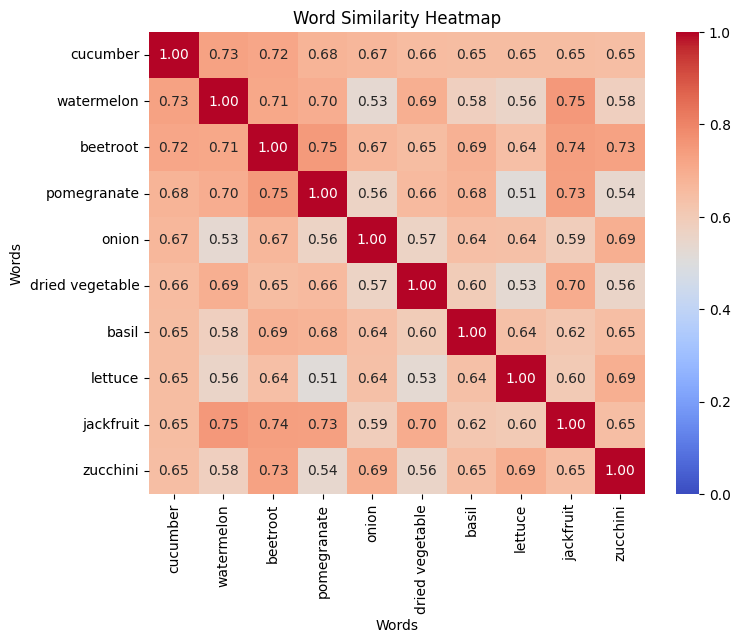

In [16]:
#Plotting the best similar words using NLP
def get_top_correlated_words(input_name, name_list, top_n=10, threshold=0.1):
    # Compute similarity scores between the input name and each word in the list
    input_doc = nlp(input_name)
    similarity_scores = {}
    
    for name in name_list:
        name_doc = nlp(name)
        if name_doc.vector_norm == 0 or input_doc.vector_norm == 0:
            similarity_scores[name] = 0
        else:
            similarity_scores[name] = input_doc.similarity(name_doc)
    
    # Filter names based on the similarity threshold
    filtered_names = {name: score for name, score in similarity_scores.items() if score > threshold}
    
    # Sort filtered names by similarity scores in descending order
    sorted_names = sorted(filtered_names, key=filtered_names.get, reverse=True)
    
    # Return the top N names
    return sorted_names[:top_n]

def compute_similarity_matrix(name_list):
    # Initialize a DataFrame with index and columns as name_list
    similarity_matrix = pd.DataFrame(index=name_list, columns=name_list)
    
    # Compute similarity scores
    for i in range(len(name_list)):
        for j in range(i, len(name_list)):
            name_i = name_list[i]
            name_j = name_list[j]
            
            # Compute similarity
            doc_i = nlp(name_i)
            doc_j = nlp(name_j)
            
            if doc_i.vector_norm == 0 or doc_j.vector_norm == 0:
                similarity = 0
            else:
                similarity = doc_i.similarity(doc_j)
            
            # Fill in the similarity matrix
            similarity_matrix.loc[name_i, name_j] = similarity
            similarity_matrix.loc[name_j, name_i] = similarity  # Symmetric matrix
    
    # Convert the similarity matrix to numeric types
    similarity_matrix = similarity_matrix.astype(float)
    
    return similarity_matrix

def plot_similarity_heatmap(similarity_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, fmt='.2f')
    plt.title('Word Similarity Heatmap')
    plt.xlabel('Words')
    plt.ylabel('Words')
    plt.show()
if input_name_data in filtered_products:
    # Get top correlated words
    top_words = get_top_correlated_words(input_name_data, unique_products)

    # Compute similarity matrix for the top words
    similarity_matrix = compute_similarity_matrix(top_words)

    # Plot the heatmap
    plot_similarity_heatmap(similarity_matrix)

Model 1 -> Given a Product name return the top products bought together based on Past Data

In [17]:
def top_co_purchased(product_name, top_n=5):
    product_id = product_mapping.get(product_name)
    if product_id is None:
        return f"Product '{product_name}' not found in the data."
    
    # Get co-occurrence counts for the given product
    co_purchased_counts = co_occurrence_matrix.loc[product_id]
    
    # Filter out products with count <= 0
    filtered_counts = co_purchased_counts[co_purchased_counts > 0]
    
    # Sort and get the top N products
    top_products = filtered_counts.sort_values(ascending=False).head(top_n)
    
    # Map back to product names
    top_products_names = top_products.index.map(product_mapping_inv)
    
    # Return a list of product names
    return top_products_names.tolist()

Model 2 -> USING COSINE SIMILARITY BETWEEN WORDS TO FIND TOP CORRELATED WORDS

In [18]:
#Function to return Top Correlated Words based on Cosine simalirity between the words 
def get_names(input_name, name_list, threshold=0.6):
    
    input_doc = nlp(input_name)
    
    similarity_scores = {}


    for name in name_list:
        name_doc = nlp(name)
        if name_doc.vector_norm == 0 or input_doc.vector_norm == 0:
            similarity_scores[name] = 0
        else:
            similarity_scores[name] = input_doc.similarity(name_doc)
    
    # Filter names based on the similarity threshold
    filtered_names = {name: score for name, score in similarity_scores.items() if score > threshold}
    
    # Sort filtered names by similarity scores in descending order
    sorted_names = sorted(filtered_names, key=filtered_names.get, reverse=True)
    
    return sorted_names[:10]  # Return only the top 10 names

Model 3 -> Using Item to Item based collaborative filtering

In [19]:
product_vectors = pivot_table.values
cosine_sim_matrix = cosine_similarity(product_vectors.T)

# Create a DataFrame to display the similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=pivot_table.columns, columns=pivot_table.columns)

def recommend_top_5_similar_products(product_name):
    product_id = product_mapping.get(product_name)
    # Get the similarity scores for the given product
    similarity_scores = cosine_sim_df[product_id]
    
    # Sort the scores in descending order and exclude the given product itself
    top_5_products = similarity_scores.sort_values(ascending=False).index[1:6]
    
    return top_5_products

Model 4 -> Using KMEANS to Cluster the words and finding top nearest words in terms of distance within the cluster

Silhouette Coefficient: 0.3804062118286123


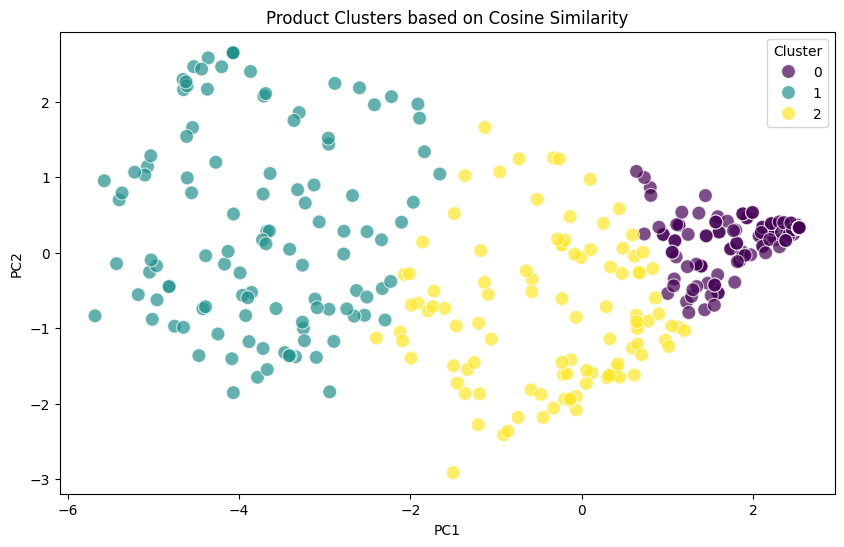

In [20]:
cosine_sim_matrix = cosine_similarity(co_occurrence_matrix)

# Convert it back to a DataFrame for easier interpretation
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=products, columns=products)

# Convert the cosine similarity matrix to a distance matrix
# Distance = 1 - Similarity
distance_matrix = 1 - cosine_sim_matrix

# Apply K-Means clustering
num_clusters = 3 # You can choose an appropriate number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(distance_matrix)

# Add cluster labels to the products
cosine_sim_df['Cluster'] = kmeans.labels_

# Calculate silhouette coefficient
silhouette_avg = silhouette_score(distance_matrix, kmeans.labels_)
print(f'Silhouette Coefficient: {silhouette_avg}')

# Visualize the clusters using PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(distance_matrix)

# Create a DataFrame for the PCA components
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = kmeans.labels_
product_clusters = pd.DataFrame({
    'Product': products,
    'Cluster': kmeans.labels_
})

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.title('Product Clusters based on Cosine Similarity')
plt.legend(title='Cluster')
plt.show()

In [21]:
def top_cluster_co_purchased(product_name, top_n=5):
    # Map product name to product ID
    product_id = product_mapping.get(product_name)
    if product_id is None:
        return f"Product '{product_name}' not found in the data."
    
    # Find the cluster of the given product
    cluster_label = product_clusters[product_clusters['Product'] == product_id]['Cluster'].values[0]
    
    # Get all products in the same cluster
    cluster_products = product_clusters[product_clusters['Cluster'] == cluster_label]['Product'].tolist()
    
    # Create a DataFrame to hold co-occurrence counts within the cluster
    cluster_co_occurrence_matrix = co_occurrence_matrix.loc[cluster_products, cluster_products]
    
    # Get co-occurrence counts for the given product within the cluster
    co_purchased_counts = cluster_co_occurrence_matrix.loc[product_id]
    
    # Filter out products with count <= 0
    filtered_counts = co_purchased_counts[co_purchased_counts > 0]
    
    # Sort and get the top N products
    top_products = filtered_counts.sort_values(ascending=False).head(top_n)
    
    # Map back to product names
    top_products_names = top_products.index.map(product_mapping_inv)
    
    # Return a list of product names
    return top_products_names.tolist()

In [22]:
#Input_product:
input_name="cucumber"
product_id = product_mapping.get(input_name)

In [23]:
recommend_1= top_co_purchased(input_name)
recommend_1


['beetroot', 'gourds', 'watermelon', 'garlic', 'curd']

In [24]:
recommend_2=[]
if input_name in filtered_products:
    recommend_2= get_names(input_name,unique_products,threshold=0.5)
recommend_2

['cucumber',
 'watermelon',
 'beetroot',
 'pomegranate',
 'onion',
 'dried vegetable',
 'basil',
 'lettuce',
 'jackfruit',
 'zucchini']

In [25]:
recommend_3 = recommend_top_5_similar_products(input_name)
recommend_3 = recommend_3.map(product_mapping_inv)
recommend_3

Index(['fresh beans', 'garlic', 'gourds', 'blueberry', 'curry leaves'], dtype='object')

In [26]:
recommend_4 = top_cluster_co_purchased(input_name)
recommend_4

['beetroot', 'gourds', 'watermelon', 'garlic', 'curd']

In [27]:
#Final Reccomendation
recommendation = set(recommend_1) | set(recommend_2) | set(recommend_3) | set(recommend_4)
if input_name in recommendation:
    recommendation.remove(input_name)
recommendation

{'basil',
 'beetroot',
 'blueberry',
 'curd',
 'curry leaves',
 'dried vegetable',
 'fresh beans',
 'garlic',
 'gourds',
 'jackfruit',
 'lettuce',
 'onion',
 'pomegranate',
 'watermelon',
 'zucchini'}

In [ ]:
#Done#